Using device: cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335521
Layer 1 Selection Ratios - Neuron A: 0.5435, Neuron B: 0.4565
Layer 2 Selection Ratios - Neuron A: 0.4856, Neuron B: 0.5144
------------------------------------------------------------
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.202949
Layer 1 Selection Ratios - Neuron A: 0.5486, Neuron B: 0.4514
Layer 2 Selection Ratios - Neuron A: 0.4817, Neuron B: 0.5183
------------------------------------------------------------
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.050698
Layer 1 Selection Ratios - Neuron A: 0.5559, Neuron B: 0.4441
Layer 2 Selection Ratios - Neuron A: 0.4866, Neuron B: 0.5134
------------------------------------------------------------
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.760435
Layer 1 Selection Ratios - Neuron A: 0.5178, Neuron B: 0.4822
Layer 2 Selection Ratios - Neuron A: 0.4851, Neuron B: 0.5149
------------------------------------------------------------
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.3655

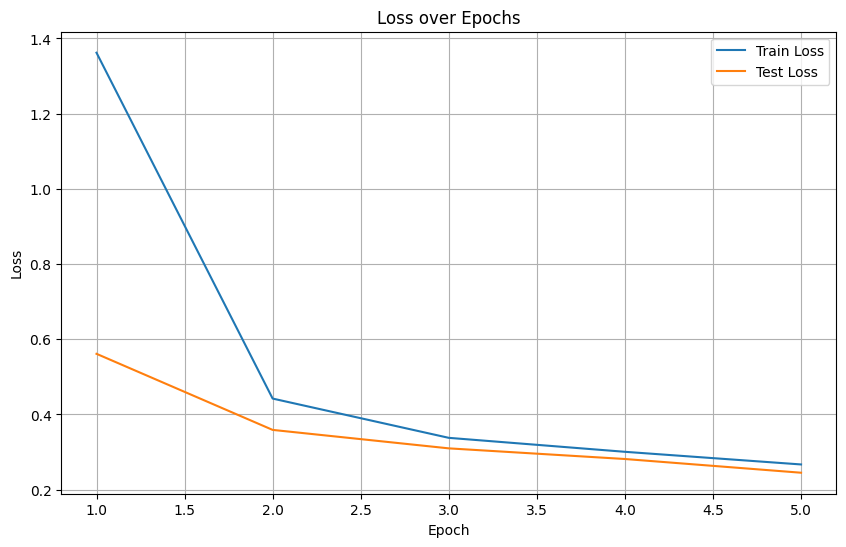

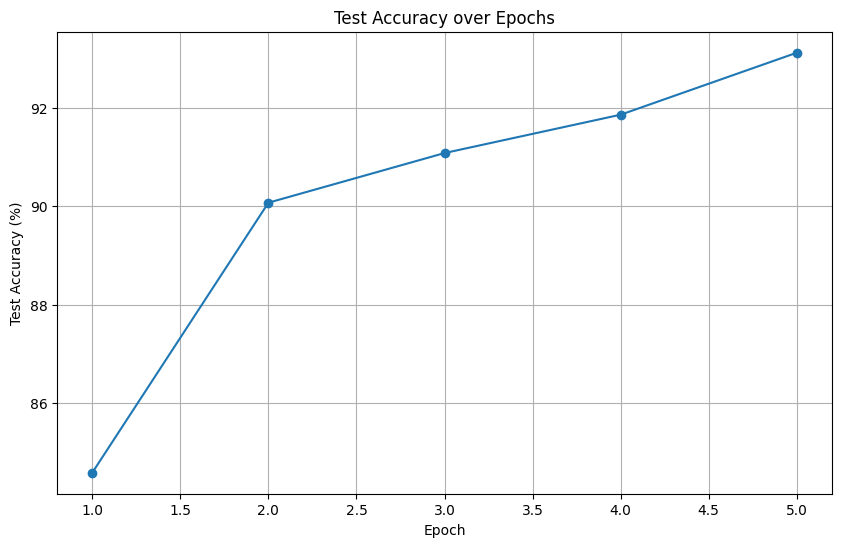

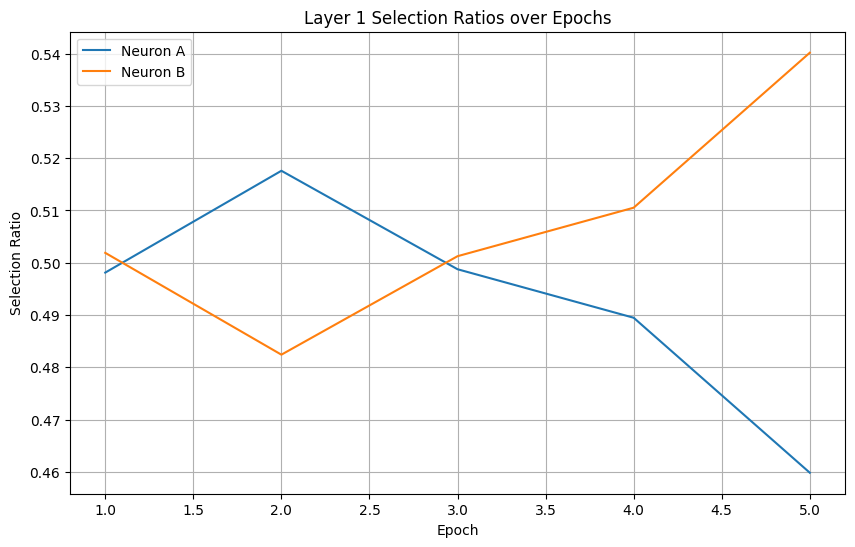

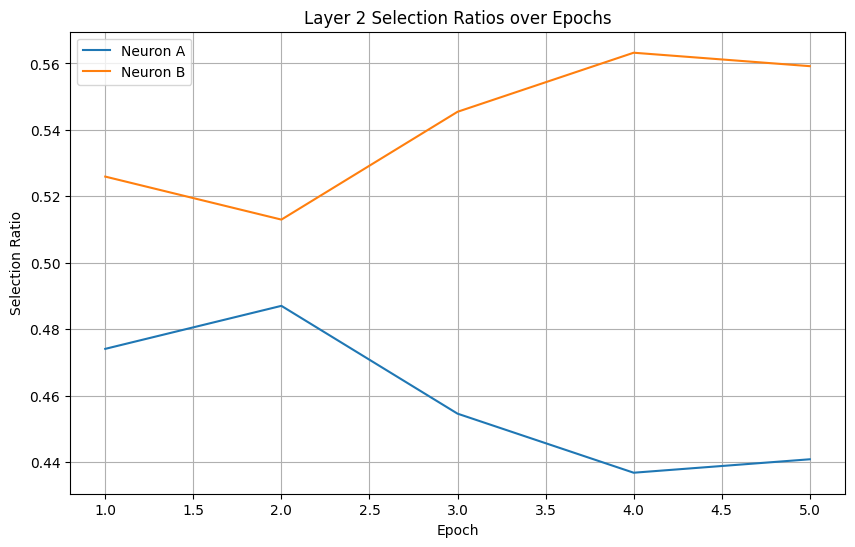

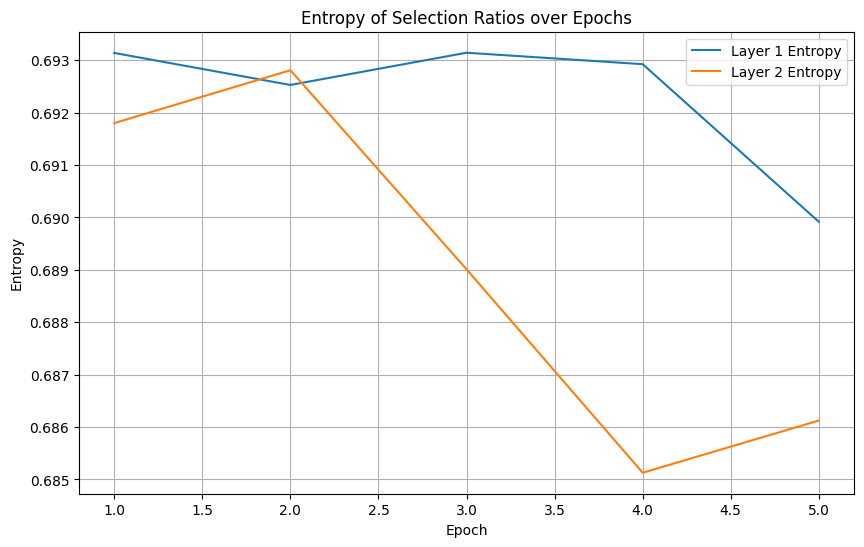

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

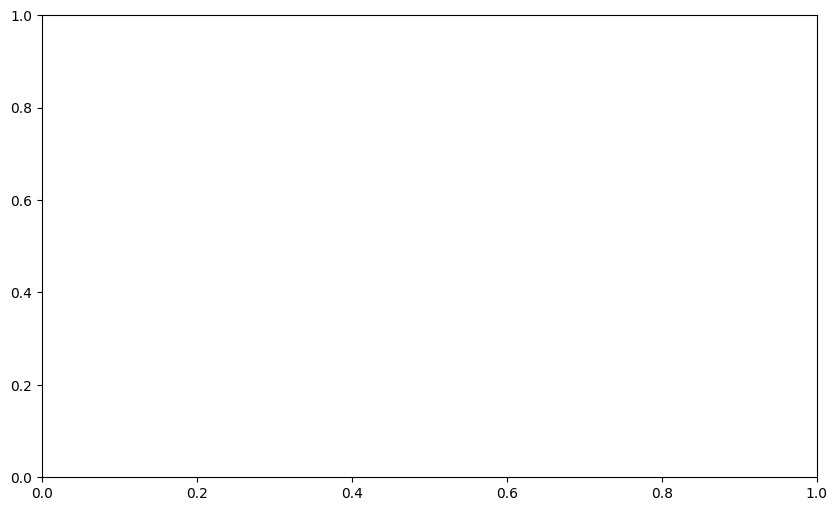

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define the custom neuron module
class CustomNeuron(nn.Module):
    def __init__(self, input_size):
        super(CustomNeuron, self).__init__()
        # Selection neuron (linear layer)
        self.selection_layer = nn.Linear(input_size, 1)
        
        # Computation neurons (linear layers)
        self.comp_layer_a = nn.Linear(input_size, 1)
        self.comp_layer_b = nn.Linear(input_size, 1)
        
        self.threshold = 0.5  # Threshold for selection
        
    def forward(self, x):
        # Selection neuron computation
        selection_output = torch.sigmoid(self.selection_layer(x))  # Shape: [batch_size, 1]
        
        # Apply the Straight-Through Estimator (STE)
        with torch.no_grad():
            selected_mask_hard = (selection_output < self.threshold).float()
        # Ensure gradients flow through selection_output
        selected_mask = selected_mask_hard - selection_output.detach() + selection_output
        
        # Compute outputs for both computation neurons
        comp_output_a = torch.relu(self.comp_layer_a(x))  # Shape: [batch_size, 1]
        comp_output_b = torch.relu(self.comp_layer_b(x))  # Shape: [batch_size, 1]
        
        # Select the computation neuron output
        comp_output = selected_mask * comp_output_a + (1 - selected_mask) * comp_output_b  # Shape: [batch_size, 1]
        
        # Store the hard selection mask for observation
        self.selected_mask_hard = selected_mask_hard.detach()  # Detach to prevent storing the computation graph
        
        return comp_output

# Define the custom layer module
class CustomLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomLayer, self).__init__()
        self.neurons = nn.ModuleList([CustomNeuron(input_size) for _ in range(output_size)])
        
    def forward(self, x):
        # x should be of shape [batch_size, input_size]
        outputs = []
        selected_masks_hard = []
        for neuron in self.neurons:
            output = neuron(x)  # Each output is [batch_size, 1]
            outputs.append(output)
            selected_masks_hard.append(neuron.selected_mask_hard)  # Each selected_mask_hard is [batch_size, 1]
        # Concatenate outputs along the feature dimension
        x_out = torch.cat(outputs, dim=1)  # Shape: [batch_size, output_size]
        # Stack selected_masks_hard to form a tensor of shape [batch_size, output_size]
        selected_masks_hard = torch.cat(selected_masks_hard, dim=1)  # Shape: [batch_size, output_size]
        self.selected_masks_hard = selected_masks_hard  # Store for observation
        return x_out

# Define the custom network
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.layer1 = CustomLayer(28*28, 64)  # Input layer
        self.layer2 = CustomLayer(64, 64)     # Hidden layer
        self.fc = nn.Linear(64, 10)           # Output layer
        
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        
        # Pass through the first custom layer
        x = self.layer1(x)
        selected_masks_layer1 = self.layer1.selected_masks_hard  # Shape: [batch_size, 64]
        
        # Pass through the second custom layer
        x = self.layer2(x)
        selected_masks_layer2 = self.layer2.selected_masks_hard  # Shape: [batch_size, 64]
        
        # Output layer
        x = self.fc(x)
        
        # Store selected masks for observation
        self.selected_masks_layer1 = selected_masks_layer1
        self.selected_masks_layer2 = selected_masks_layer2
        
        return x

# Function to compute entropy
def compute_entropy(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

# Prepare the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                              transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1000,
                                          shuffle=False)

# Initialize the network, criterion, and optimizer
model = CustomNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training settings
num_epochs = 5
log_interval = 100

# Initialize lists to store selection ratios, entropy, cosine similarity, and losses
epoch_selection_ratios_layer1 = []
epoch_selection_ratios_layer2 = []
epoch_entropy_layer1 = []
epoch_entropy_layer2 = []
epoch_cosine_similarity_layer1 = []
epoch_cosine_similarity_layer2 = []
epoch_train_losses = []
epoch_test_losses = []
epoch_test_accuracies = []

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    # Initialize selection counts for entropy calculation
    selection_counts_layer1 = torch.zeros(model.layer1.neurons.__len__()).to(device)  # Shape: [64]
    selection_counts_layer2 = torch.zeros(model.layer2.neurons.__len__()).to(device)  # Shape: [64]
    total_selections_layer1 = 0
    total_selections_layer2 = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU if available
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss.item() * data.size(0)
        
        # Collect selection counts
        selected_masks_layer1 = model.selected_masks_layer1  # Shape: [batch_size, 64]
        selected_masks_layer2 = model.selected_masks_layer2  # Shape: [batch_size, 64]
        
        # Update selection counts for Layer 1
        # Sum over batch to get counts per neuron
        selection_counts_layer1 += selected_masks_layer1.sum(dim=0)  # Shape: [64]
        total_selections_layer1 += selected_masks_layer1.numel()  # Scalar
        
        # Update selection counts for Layer 2
        selection_counts_layer2 += selected_masks_layer2.sum(dim=0)  # Shape: [64]
        total_selections_layer2 += selected_masks_layer2.numel()  # Scalar
        
        if batch_idx % log_interval == 0:
            # Compute selection ratios for the current batch
            # Avoid using cumulative counts for batch ratios
            batch_ratio_A_layer1 = selected_masks_layer1.mean(dim=0).mean().item()
            batch_ratio_B_layer1 = 1 - batch_ratio_A_layer1
            batch_ratio_A_layer2 = selected_masks_layer2.mean(dim=0).mean().item()
            batch_ratio_B_layer2 = 1 - batch_ratio_A_layer2
            
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            print(f'Layer 1 Selection Ratios - Neuron A: {batch_ratio_A_layer1:.4f}, Neuron B: {batch_ratio_B_layer1:.4f}')
            print(f'Layer 2 Selection Ratios - Neuron A: {batch_ratio_A_layer2:.4f}, Neuron B: {batch_ratio_B_layer2:.4f}')
            print('-' * 60)
    
    # Compute average loss and selection ratios for the epoch
    train_loss /= len(train_loader.dataset)
    ratio_A_layer1_epoch = selection_counts_layer1.sum().item() / total_selections_layer1
    ratio_B_layer1_epoch = 1 - ratio_A_layer1_epoch
    ratio_A_layer2_epoch = selection_counts_layer2.sum().item() / total_selections_layer2
    ratio_B_layer2_epoch = 1 - ratio_A_layer2_epoch
    
    print(f'\nTrain Epoch {epoch}: Average loss: {train_loss:.4f}')
    print(f'Layer 1 Selection Ratios - Neuron A: {ratio_A_layer1_epoch:.4f}, Neuron B: {ratio_B_layer1_epoch:.4f}')
    print(f'Layer 2 Selection Ratios - Neuron A: {ratio_A_layer2_epoch:.4f}, Neuron B: {ratio_B_layer2_epoch:.4f}')
    
    # Compute entropy for the epoch
    # For Layer 1
    pA_layer1 = ratio_A_layer1_epoch
    pB_layer1 = ratio_B_layer1_epoch
    entropy_layer1 = compute_entropy(pA_layer1)
    
    # For Layer 2
    pA_layer2 = ratio_A_layer2_epoch
    pB_layer2 = ratio_B_layer2_epoch
    entropy_layer2 = compute_entropy(pA_layer2)
    
    print(f'Layer 1 Entropy of Selection Ratios: {entropy_layer1:.4f}')
    print(f'Layer 2 Entropy of Selection Ratios: {entropy_layer2:.4f}')
    
    # Compute Cosine Similarity for the epoch
    cos_sim_layer1 = []
    cos_sim_layer2 = []
    
    for neuron in model.layer1.neurons:
        # Get weights from comp_layer_a and comp_layer_b
        weight_a = neuron.comp_layer_a.weight.data.view(-1)
        weight_b = neuron.comp_layer_b.weight.data.view(-1)
        cos_sim = F.cosine_similarity(weight_a, weight_b, dim=0).item()
        cos_sim_layer1.append(cos_sim)
    
    for neuron in model.layer2.neurons:
        # Get weights from comp_layer_a and comp_layer_b
        weight_a = neuron.comp_layer_a.weight.data.view(-1)
        weight_b = neuron.comp_layer_b.weight.data.view(-1)
        cos_sim = F.cosine_similarity(weight_a, weight_b, dim=0).item()
        cos_sim_layer2.append(cos_sim)
    
    # Compute average cosine similarity for each layer
    avg_cos_sim_layer1 = np.mean(cos_sim_layer1)
    avg_cos_sim_layer2 = np.mean(cos_sim_layer2)
    
    print(f'Layer 1 Cosine Similarity between Neuron A and B: {avg_cos_sim_layer1:.4f}')
    print(f'Layer 2 Cosine Similarity between Neuron A and B: {avg_cos_sim_layer2:.4f}\n')
    
    # Store metrics for plotting
    epoch_selection_ratios_layer1.append((ratio_A_layer1_epoch, ratio_B_layer1_epoch))
    epoch_selection_ratios_layer2.append((ratio_A_layer2_epoch, ratio_B_layer2_epoch))
    epoch_entropy_layer1.append(entropy_layer1)
    epoch_entropy_layer2.append(entropy_layer2)
    epoch_cosine_similarity_layer1.append(avg_cos_sim_layer1)
    epoch_cosine_similarity_layer2.append(avg_cos_sim_layer2)
    epoch_train_losses.append(train_loss)
    
    # Test the model after each epoch
    model.eval()
    test_loss = 0
    correct = 0
    # Initialize selection counts for entropy calculation
    selection_counts_layer1_test = torch.zeros(model.layer1.neurons.__len__()).to(device)  # Shape: [64]
    selection_counts_layer2_test = torch.zeros(model.layer2.neurons.__len__()).to(device)  # Shape: [64]
    total_selections_layer1_test = 0
    total_selections_layer2_test = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)      # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Collect selection counts
            selected_masks_layer1 = model.selected_masks_layer1  # Shape: [batch_size, 64]
            selected_masks_layer2 = model.selected_masks_layer2  # Shape: [batch_size, 64]
            
            # Update selection counts for Layer 1
            selection_counts_layer1_test += selected_masks_layer1.sum(dim=0)  # Shape: [64]
            total_selections_layer1_test += selected_masks_layer1.numel()  # Scalar
            
            # Update selection counts for Layer 2
            selection_counts_layer2_test += selected_masks_layer2.sum(dim=0)  # Shape: [64]
            total_selections_layer2_test += selected_masks_layer2.numel()  # Scalar
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    ratio_A_layer1_test = selection_counts_layer1_test.sum().item() / total_selections_layer1_test
    ratio_B_layer1_test = 1 - ratio_A_layer1_test
    ratio_A_layer2_test = selection_counts_layer2_test.sum().item() / total_selections_layer2_test
    ratio_B_layer2_test = 1 - ratio_A_layer2_test
    
    # Compute entropy for the test
    entropy_layer1_test = compute_entropy(ratio_A_layer1_test)
    entropy_layer2_test = compute_entropy(ratio_A_layer2_test)
    
    # Compute Cosine Similarity for the test
    cos_sim_layer1_test = []
    cos_sim_layer2_test = []
    
    for neuron in model.layer1.neurons:
        # Get weights from comp_layer_a and comp_layer_b
        weight_a = neuron.comp_layer_a.weight.data.view(-1)
        weight_b = neuron.comp_layer_b.weight.data.view(-1)
        cos_sim = F.cosine_similarity(weight_a, weight_b, dim=0).item()
        cos_sim_layer1_test.append(cos_sim)
    
    for neuron in model.layer2.neurons:
        # Get weights from comp_layer_a and comp_layer_b
        weight_a = neuron.comp_layer_a.weight.data.view(-1)
        weight_b = neuron.comp_layer_b.weight.data.view(-1)
        cos_sim = F.cosine_similarity(weight_a, weight_b, dim=0).item()
        cos_sim_layer2_test.append(cos_sim)
    
    # Compute average cosine similarity for each layer
    avg_cos_sim_layer1_test = np.mean(cos_sim_layer1_test)
    avg_cos_sim_layer2_test = np.mean(cos_sim_layer2_test)
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({accuracy:.2f}%)')
    print(f'Layer 1 Selection Ratios - Neuron A: {ratio_A_layer1_test:.4f}, Neuron B: {ratio_B_layer1_test:.4f}')
    print(f'Layer 2 Selection Ratios - Neuron A: {ratio_A_layer2_test:.4f}, Neuron B: {ratio_B_layer2_test:.4f}')
    print(f'Layer 1 Entropy of Selection Ratios: {entropy_layer1_test:.4f}')
    print(f'Layer 2 Entropy of Selection Ratios: {entropy_layer2_test:.4f}')
    print(f'Layer 1 Cosine Similarity between Neuron A and B: {avg_cos_sim_layer1_test:.4f}')
    print(f'Layer 2 Cosine Similarity between Neuron A and B: {avg_cos_sim_layer2_test:.4f}\n')
    
    # Store test loss and accuracy for plotting
    epoch_test_losses.append(test_loss)
    epoch_test_accuracies.append(accuracy)
    epoch_cosine_similarity_layer1.append(avg_cos_sim_layer1_test)
    epoch_cosine_similarity_layer2.append(avg_cos_sim_layer2_test)

# Plot training and test loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs +1), epoch_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs +1), epoch_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

# Plot test accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs +1), epoch_test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.grid(True)
plt.show()

# Plot selection ratios over epochs for Layer 1
ratios_A_layer1 = [ratios[0] for ratios in epoch_selection_ratios_layer1]
ratios_B_layer1 = [ratios[1] for ratios in epoch_selection_ratios_layer1]

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs +1), ratios_A_layer1, label='Neuron A')
plt.plot(range(1, num_epochs +1), ratios_B_layer1, label='Neuron B')
plt.xlabel('Epoch')
plt.ylabel('Selection Ratio')
plt.legend()
plt.title('Layer 1 Selection Ratios over Epochs')
plt.grid(True)
plt.show()

# Plot selection ratios over epochs for Layer 2
ratios_A_layer2 = [ratios[0] for ratios in epoch_selection_ratios_layer2]
ratios_B_layer2 = [ratios[1] for ratios in epoch_selection_ratios_layer2]

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs +1), ratios_A_layer2, label='Neuron A')
plt.plot(range(1, num_epochs +1), ratios_B_layer2, label='Neuron B')
plt.xlabel('Epoch')
plt.ylabel('Selection Ratio')
plt.legend()
plt.title('Layer 2 Selection Ratios over Epochs')
plt.grid(True)
plt.show()

# Plot entropy of selection ratios over epochs for Layer 1 and Layer 2
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs +1), epoch_entropy_layer1, label='Layer 1 Entropy')
plt.plot(range(1, num_epochs +1), epoch_entropy_layer2, label='Layer 2 Entropy')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.legend()
plt.title('Entropy of Selection Ratios over Epochs')
plt.grid(True)
plt.show()

# Plot cosine similarity of computation neurons over epochs for Layer 1 and Layer 2
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs +1), epoch_cosine_similarity_layer1, label='Layer 1 Cosine Similarity')
plt.plot(range(1, num_epochs +1), epoch_cosine_similarity_layer2, label='Layer 2 Cosine Similarity')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('Cosine Similarity between Neuron A and B over Epochs')
plt.grid(True)
plt.show()


In [5]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

class SelectionNeuron:
    def __init__(self, input_size):
        # Initialize weights and threshold for selection
        self.weights = np.random.randn(input_size)
        self.threshold = 0.5
        self.learning_rate = 0.01

    def forward(self, x):
        # Compute selection signal
        self.x = x
        self.z = np.dot(x, self.weights)
        self.output = self.sigmoid(self.z)
        
        # Determine if the neuron activates based on the threshold
        self.is_selected = self.output > self.threshold
        return self.is_selected

    def backpropagate(self, next_gradient):
        # Only backpropagate if the neuron was selected
        if self.is_selected:
            sigmoid_derivative = self.output * (1 - self.output)
            gradient = next_gradient * sigmoid_derivative * self.x
            self.weights -= self.learning_rate * gradient

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))


class ComputationNeuron:
    def __init__(self, input_size):
        # Initialize weights for computation
        self.weights = np.random.randn(input_size)
        self.learning_rate = 0.01

    def forward(self, x):
        # Compute output if selected
        self.x = x
        self.z = np.dot(x, self.weights)
        self.output = self.sigmoid(self.z)
        return self.output

    def backpropagate(self, target):
        # Compute error and gradient
        error = self.output - target
        sigmoid_derivative = self.output * (1 - self.output)
        gradient = error * sigmoid_derivative * self.x
        self.weights -= self.learning_rate * gradient
        return error * sigmoid_derivative  # Return gradient for previous neuron

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

# Define input size and target
input_size = 4
target = np.random.rand()

# Initialize neurons
selection_neuron = SelectionNeuron(input_size)
computation_neuron = ComputationNeuron(input_size)

# Generate random input
input_data = np.random.rand(input_size)

# Forward pass through selection neuron
is_selected = selection_neuron.forward(input_data)
if is_selected:
    # If selected, pass input to computation neuron
    computation_output = computation_neuron.forward(input_data)
    print("Computation neuron output:", computation_output)
    
    # Backpropagation
    # First, through the computation neuron
    computation_gradient = computation_neuron.backpropagate(target)
    # Then, through the selection neuron
    selection_neuron.backpropagate(computation_gradient)
else:
    print("Computation neuron was not activated by the selection neuron.")

# Show updated weights
print("Selection neuron weights:", selection_neuron.weights)
print("Computation neuron weights:", computation_neuron.weights)


Computation neuron output: 0.22037724410532172
Selection neuron weights: [-1.11184592  0.31893033  0.27906027  1.01055515]
Computation neuron weights: [-0.58073914 -0.5250554  -0.57130303 -0.92392078]


In [6]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

class SelectionNeuron:
    def __init__(self, input_size):
        # Initialize weights and threshold for selection
        self.weights = np.random.randn(input_size)
        self.threshold = 0.5
        self.learning_rate = 0.01

    def forward(self, x):
        # Compute selection signal
        self.x = x
        self.z = np.dot(x, self.weights)
        self.output = self.sigmoid(self.z)
        
        # Determine which computation neuron to activate
        # Here, we use the threshold to select between neuron A and B
        self.selected_neuron = 0 if self.output < self.threshold else 1
        return self.selected_neuron

    def backpropagate(self, next_gradient):
        # Backpropagate if either computation neuron was activated
        sigmoid_derivative = self.output * (1 - self.output)
        gradient = next_gradient * sigmoid_derivative * self.x
        self.weights -= self.learning_rate * gradient

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

class ComputationNeuron:
    def __init__(self, input_size):
        # Initialize weights for computation
        self.weights = np.random.randn(input_size)
        self.learning_rate = 0.01

    def forward(self, x):
        # Compute output
        self.x = x
        self.z = np.dot(x, self.weights)
        self.output = self.sigmoid(self.z)
        return self.output

    def backpropagate(self, target):
        # Compute error and gradient
        error = self.output - target
        sigmoid_derivative = self.output * (1 - self.output)
        gradient = error * sigmoid_derivative * self.x
        self.weights -= self.learning_rate * gradient
        return error * sigmoid_derivative  # Return gradient for previous neuron

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

# Define input size, target, and number of training steps
input_size = 4
target = np.random.rand()
num_steps = 10

# Initialize neurons
selection_neuron = SelectionNeuron(input_size)
computation_neuron_a = ComputationNeuron(input_size)
computation_neuron_b = ComputationNeuron(input_size)

# Training loop
for step in range(num_steps):
    # Generate random input data
    input_data = np.random.rand(input_size)
    
    # Forward pass through selection neuron
    selected_neuron = selection_neuron.forward(input_data)
    
    # Use selected computation neuron
    if selected_neuron == 0:
        output = computation_neuron_a.forward(input_data)
        print(f"Step {step + 1}: Computation Neuron A output:", output)
        # Backpropagate for computation neuron A
        computation_gradient = computation_neuron_a.backpropagate(target)
    else:
        output = computation_neuron_b.forward(input_data)
        print(f"Step {step + 1}: Computation Neuron B output:", output)
        # Backpropagate for computation neuron B
        computation_gradient = computation_neuron_b.backpropagate(target)
    
    # Backpropagate through selection neuron
    selection_neuron.backpropagate(computation_gradient)
    
    # Show updated weights for tracking
    print("Updated Selection Neuron weights:", selection_neuron.weights)
    print("Updated Computation Neuron A weights:", computation_neuron_a.weights)
    print("Updated Computation Neuron B weights:", computation_neuron_b.weights)
    print("---------------------------------------------------------")


Step 1: Computation Neuron B output: 0.3816220997280447
Updated Selection Neuron weights: [-1.11188067  0.31890104  0.27903985  1.01051349]
Updated Computation Neuron A weights: [-0.58087813 -0.52516981 -0.57138017 -0.92408284]
Updated Computation Neuron B weights: [-2.61255134  0.9503648   0.81643896 -1.52388362]
---------------------------------------------------------
Step 2: Computation Neuron A output: 0.19746443436931804
Updated Selection Neuron weights: [-1.11182564  0.31891503  0.27907589  1.01055501]
Updated Computation Neuron A weights: [-0.5806578  -0.52511378 -0.57123586 -0.9239166 ]
Updated Computation Neuron B weights: [-2.61255134  0.9503648   0.81643896 -1.52388362]
---------------------------------------------------------
Step 3: Computation Neuron B output: 0.6215486450639714
Updated Selection Neuron weights: [-1.11183228  0.3188282   0.27905152  1.01054571]
Updated Computation Neuron A weights: [-0.5806578  -0.52511378 -0.57123586 -0.9239166 ]
Updated Computation Neu